# SAM3 Boundary Generation Strategy Comparison

This notebook demonstrates the three different inference strategies for generating boundary masks:

1. **Baseline**: Process full image (may miss small/distant objects)
2. **Multi-Crop**: Split into fixed grid (2x2 or 2x1)
3. **Tiled**: Sliding window with overlap (best for boundary objects)

We'll run all three on a single sample image and visualize the results side-by-side.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch

from transformers import Sam3Processor, Sam3Model

# Import our strategy functions
from generate_sam3_masks import (
    load_sam3_model,
    strategy_baseline,
    strategy_multi_crop,
    strategy_tiled,
    THIN_CLASS_PROMPTS
)

## Configuration

In [2]:
# Path to your Cityscapes dataset
CITYSCAPES_ROOT = Path("../data/cityscapes")

# Select a sample image (you can change this)
SAMPLE_IMAGE = CITYSCAPES_ROOT / "leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Verify image exists
if not SAMPLE_IMAGE.exists():
    print(f"⚠️ Sample image not found: {SAMPLE_IMAGE}")
    print("Please update SAMPLE_IMAGE path to a valid Cityscapes image")
else:
    print(f"✓ Sample image found: {SAMPLE_IMAGE.name}")

Using device: cuda
✓ Sample image found: frankfurt_000000_000294_leftImg8bit.png


## Load SAM3 Model

In [3]:
model, processor = load_sam3_model(DEVICE)

Loading SAM3 model on cuda...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

SAM3 model loaded successfully


## Load Sample Image

Image size: (2048, 1024)


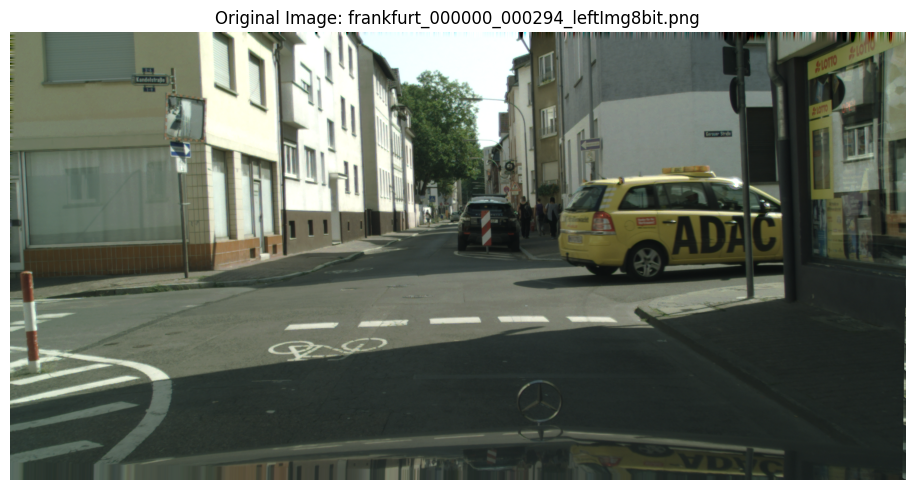

In [4]:
image = Image.open(SAMPLE_IMAGE).convert("RGB")
print(f"Image size: {image.size}")  # Should be (2048, 1024) for Cityscapes

# Display the original image
plt.figure(figsize=(15, 5))
plt.imshow(image)
plt.title(f"Original Image: {SAMPLE_IMAGE.name}")
plt.axis('off')
plt.tight_layout()
plt.show()

## Strategy 1: Baseline (No Crop)

Process the full image directly. This is fast but may miss small/distant objects due to resolution loss.

In [5]:
print("Running Baseline strategy...")
boundary_baseline = strategy_baseline(image, model, processor, DEVICE)
print(f"✓ Baseline complete. Boundary pixels: {boundary_baseline.sum()}")

Running Baseline strategy...
✓ Baseline complete. Boundary pixels: 41565


## Strategy 2: Multi-Crop (2x2 Grid)

Split the image into 4 quadrants and process each independently. Better captures objects in each region.

In [6]:
print("Running Multi-Crop strategy (2x2 grid)...")
boundary_multi_crop = strategy_multi_crop(
    image, model, processor, DEVICE, 
    grid_size=(2, 2)
)
print(f"✓ Multi-Crop complete. Boundary pixels: {boundary_multi_crop.sum()}")

Running Multi-Crop strategy (2x2 grid)...
✓ Multi-Crop complete. Boundary pixels: 39279


## Strategy 3: Tiled (Sliding Window)

Use overlapping sliding windows. Best for capturing objects that lie on crop boundaries.

In [7]:
print("Running Tiled strategy (1024x1024 windows, stride 512)...")
boundary_tiled = strategy_tiled(
    image, model, processor, DEVICE,
    window_size=1024,
    stride=512
)
print(f"✓ Tiled complete. Boundary pixels: {boundary_tiled.sum()}")

Running Tiled strategy (1024x1024 windows, stride 512)...


✓ Tiled complete. Boundary pixels: 46743


## Side-by-Side Comparison

Let's visualize all three strategies together.

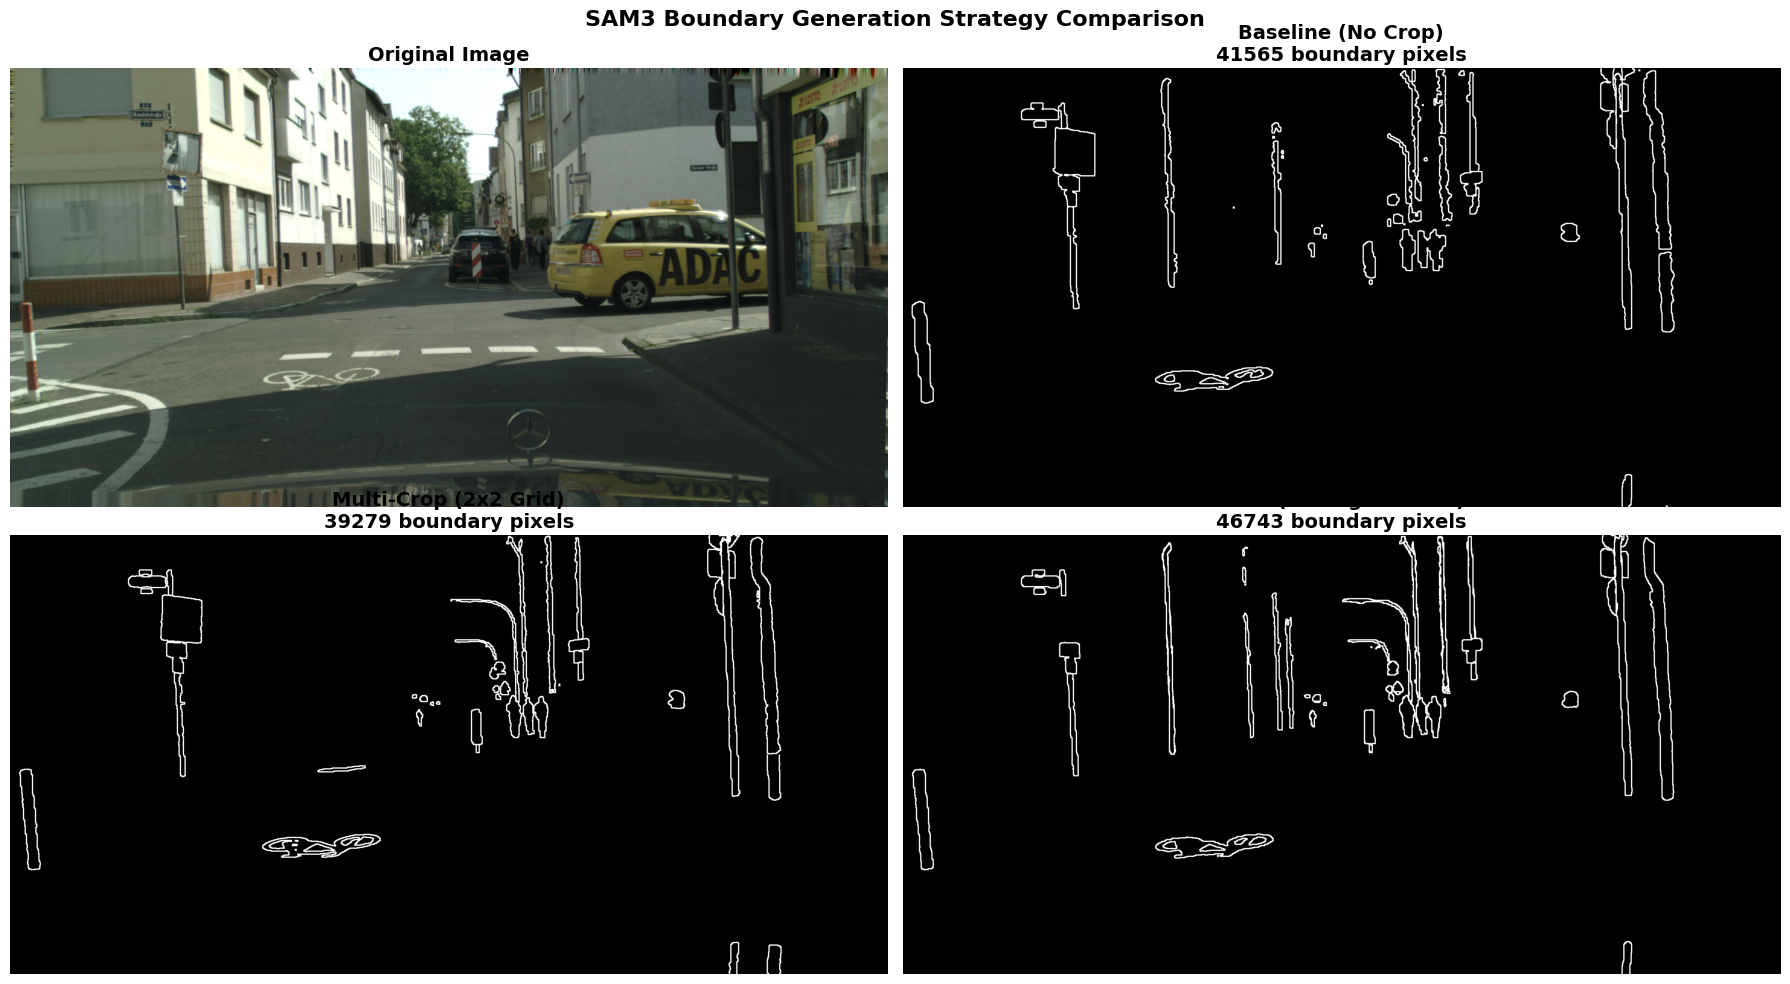

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Original image
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Baseline
axes[0, 1].imshow(boundary_baseline, cmap='gray')
axes[0, 1].set_title(f"Baseline (No Crop)\n{boundary_baseline.sum()} boundary pixels", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Multi-Crop
axes[1, 0].imshow(boundary_multi_crop, cmap='gray')
axes[1, 0].set_title(f"Multi-Crop (2x2 Grid)\n{boundary_multi_crop.sum()} boundary pixels", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Tiled
axes[1, 1].imshow(boundary_tiled, cmap='gray')
axes[1, 1].set_title(f"Tiled (Sliding Window)\n{boundary_tiled.sum()} boundary pixels", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle("SAM3 Boundary Generation Strategy Comparison", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Overlay Comparison

Overlay the boundaries on the original image to better see the differences.

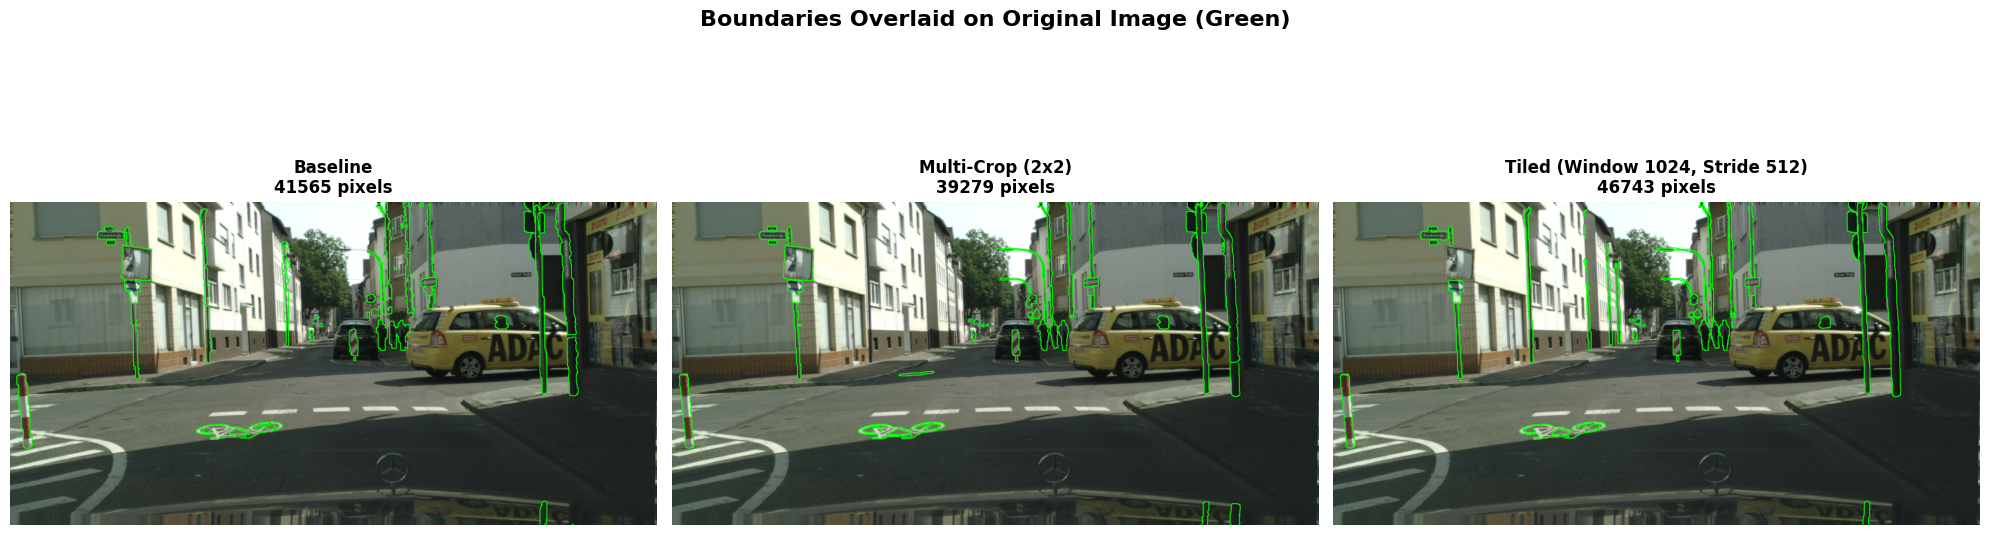

In [9]:
def overlay_boundary(image, boundary, color=(0, 255, 0)):
    """Overlay boundary on image"""
    img_array = np.array(image).copy()
    img_array[boundary] = color
    return img_array

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Baseline overlay
axes[0].imshow(overlay_boundary(image, boundary_baseline))
axes[0].set_title(f"Baseline\n{boundary_baseline.sum()} pixels", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Multi-Crop overlay
axes[1].imshow(overlay_boundary(image, boundary_multi_crop))
axes[1].set_title(f"Multi-Crop (2x2)\n{boundary_multi_crop.sum()} pixels", fontsize=12, fontweight='bold')
axes[1].axis('off')

# Tiled overlay
axes[2].imshow(overlay_boundary(image, boundary_tiled))
axes[2].set_title(f"Tiled (Window 1024, Stride 512)\n{boundary_tiled.sum()} pixels", fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle("Boundaries Overlaid on Original Image (Green)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Difference Maps

Highlight what each strategy captures that the baseline misses.

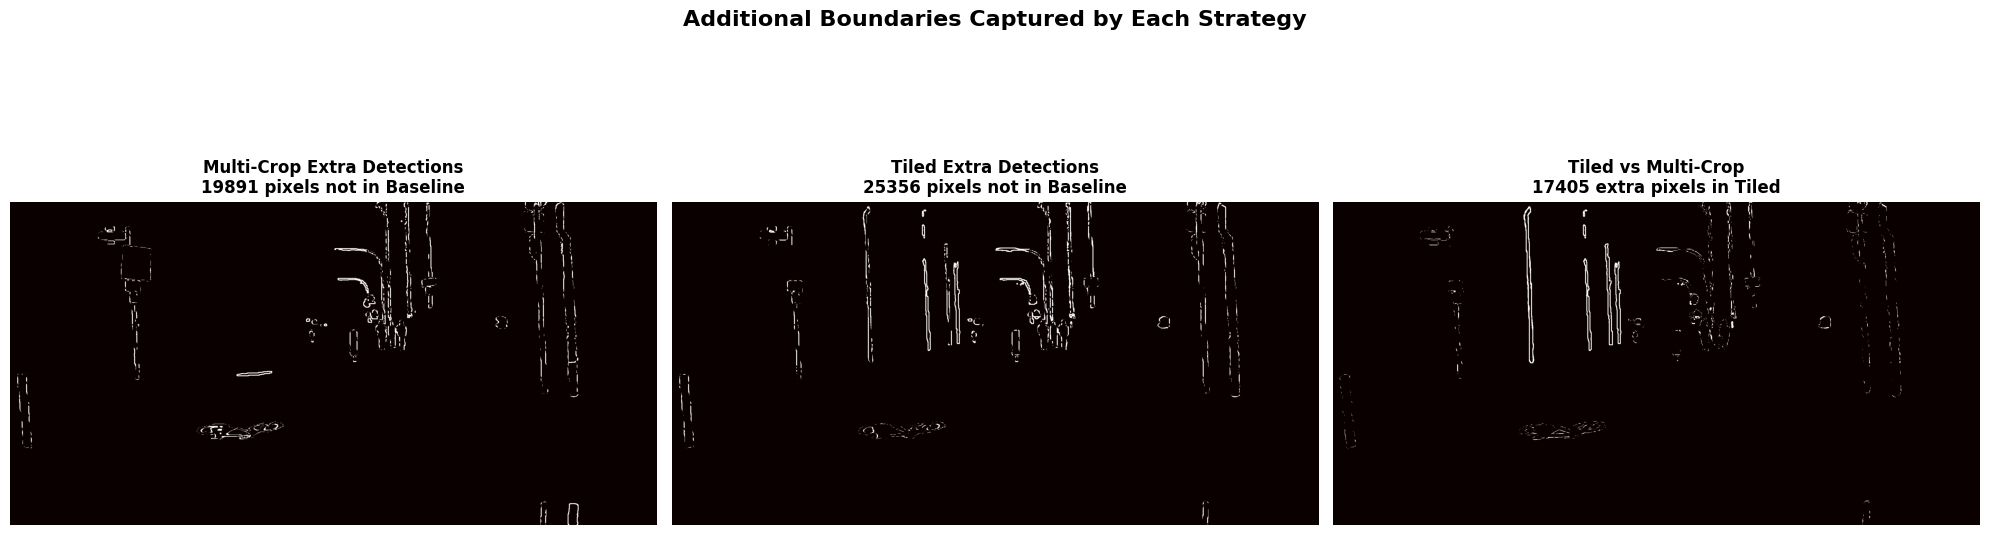

In [10]:
# Calculate differences
multi_crop_extra = boundary_multi_crop & ~boundary_baseline
tiled_extra = boundary_tiled & ~boundary_baseline
tiled_vs_multi = boundary_tiled & ~boundary_multi_crop

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Multi-crop gains over baseline
axes[0].imshow(multi_crop_extra, cmap='hot')
axes[0].set_title(f"Multi-Crop Extra Detections\n{multi_crop_extra.sum()} pixels not in Baseline", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Tiled gains over baseline
axes[1].imshow(tiled_extra, cmap='hot')
axes[1].set_title(f"Tiled Extra Detections\n{tiled_extra.sum()} pixels not in Baseline", fontsize=12, fontweight='bold')
axes[1].axis('off')

# Tiled gains over multi-crop
axes[2].imshow(tiled_vs_multi, cmap='hot')
axes[2].set_title(f"Tiled vs Multi-Crop\n{tiled_vs_multi.sum()} extra pixels in Tiled", fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle("Additional Boundaries Captured by Each Strategy", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Zoomed Region Comparison

Let's zoom into a specific region to see the differences more clearly.

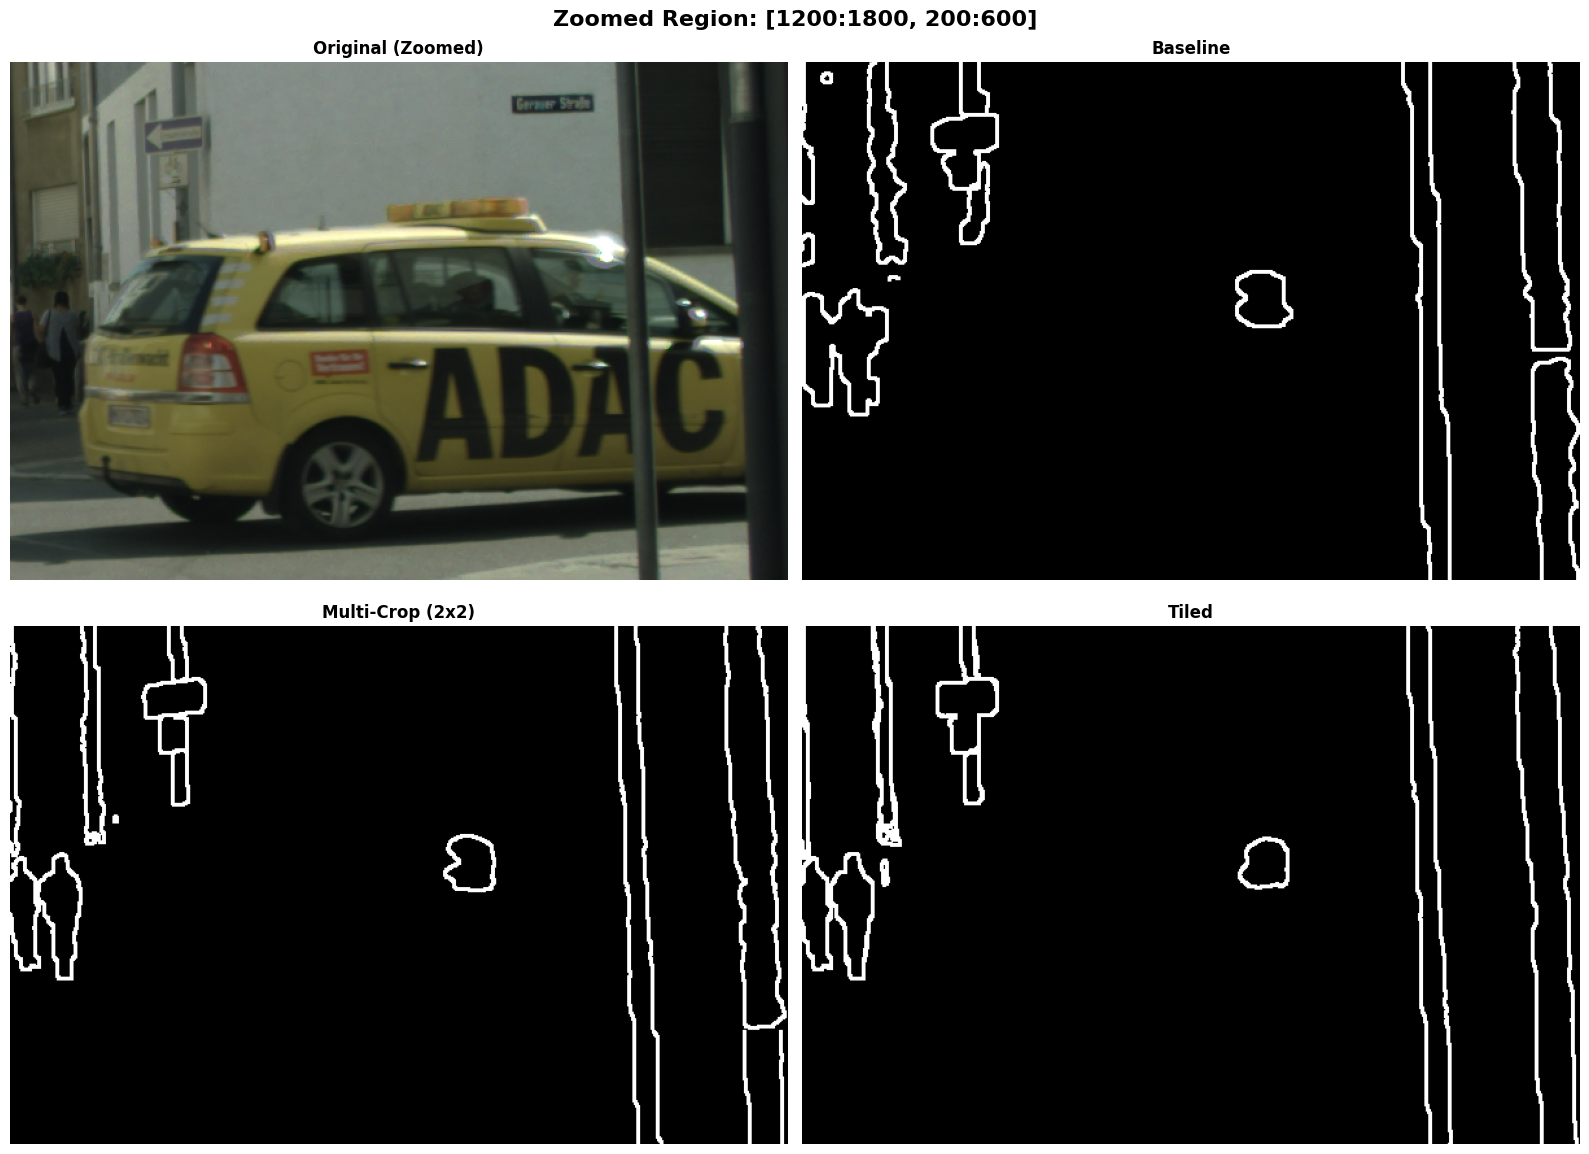

In [11]:
# Define a region with thin objects (adjust these coordinates based on your image)
# For Cityscapes, often the top-right has distant poles/signs
zoom_x1, zoom_x2 = 1200, 1800  # x coordinates
zoom_y1, zoom_y2 = 200, 600     # y coordinates

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original zoomed
img_zoomed = np.array(image)[zoom_y1:zoom_y2, zoom_x1:zoom_x2]
axes[0, 0].imshow(img_zoomed)
axes[0, 0].set_title("Original (Zoomed)", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Baseline zoomed
axes[0, 1].imshow(boundary_baseline[zoom_y1:zoom_y2, zoom_x1:zoom_x2], cmap='gray')
axes[0, 1].set_title("Baseline", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Multi-crop zoomed
axes[1, 0].imshow(boundary_multi_crop[zoom_y1:zoom_y2, zoom_x1:zoom_x2], cmap='gray')
axes[1, 0].set_title("Multi-Crop (2x2)", fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Tiled zoomed
axes[1, 1].imshow(boundary_tiled[zoom_y1:zoom_y2, zoom_x1:zoom_x2], cmap='gray')
axes[1, 1].set_title("Tiled", fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle(f"Zoomed Region: [{zoom_x1}:{zoom_x2}, {zoom_y1}:{zoom_y2}]", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary Statistics

In [12]:
print("="*60)
print("BOUNDARY DETECTION STATISTICS")
print("="*60)
print(f"Image size: {image.size[0]} x {image.size[1]} pixels")
print()
print(f"Baseline:      {boundary_baseline.sum():,} boundary pixels")
print(f"Multi-Crop:    {boundary_multi_crop.sum():,} boundary pixels (+{(boundary_multi_crop.sum() - boundary_baseline.sum()):,})")
print(f"Tiled:         {boundary_tiled.sum():,} boundary pixels (+{(boundary_tiled.sum() - boundary_baseline.sum()):,})")
print()
print(f"Multi-Crop captures {multi_crop_extra.sum():,} pixels missed by Baseline ({100*multi_crop_extra.sum()/max(boundary_baseline.sum(),1):.1f}% increase)")
print(f"Tiled captures {tiled_extra.sum():,} pixels missed by Baseline ({100*tiled_extra.sum()/max(boundary_baseline.sum(),1):.1f}% increase)")
print(f"Tiled captures {tiled_vs_multi.sum():,} pixels missed by Multi-Crop")
print("="*60)

BOUNDARY DETECTION STATISTICS
Image size: 2048 x 1024 pixels

Baseline:      41,565 boundary pixels
Multi-Crop:    39,279 boundary pixels (+-2,286)
Tiled:         46,743 boundary pixels (+5,178)

Multi-Crop captures 19,891 pixels missed by Baseline (47.9% increase)
Tiled captures 25,356 pixels missed by Baseline (61.0% increase)
Tiled captures 17,405 pixels missed by Multi-Crop


## Conclusions

Based on the visualizations above:

- **Baseline** is fast but may miss small/distant objects due to resolution loss
- **Multi-Crop** captures more details by processing higher-resolution crops
- **Tiled** captures the most details and handles objects on crop boundaries

### Recommendations:

- Use **Baseline** for quick prototyping or when speed is critical
- Use **Multi-Crop** (2x2) for a good balance of quality and speed
- Use **Tiled** for maximum quality, especially for thin objects

### Next Steps:

Run the full dataset generation with your chosen strategy:

```bash
# Baseline (fastest)
python generate_sam3_masks.py --data_root ../data/cityscapes --strategy baseline

# Multi-Crop 2x2 (balanced)
python generate_sam3_masks.py --data_root ../data/cityscapes --strategy multi_crop --grid_size 2 2

# Tiled (highest quality)
python generate_sam3_masks.py --data_root ../data/cityscapes --strategy tiled --window_size 1024 --stride 512
```


Testing Multi-Crop with 2x1 Grid (Left/Right Split)


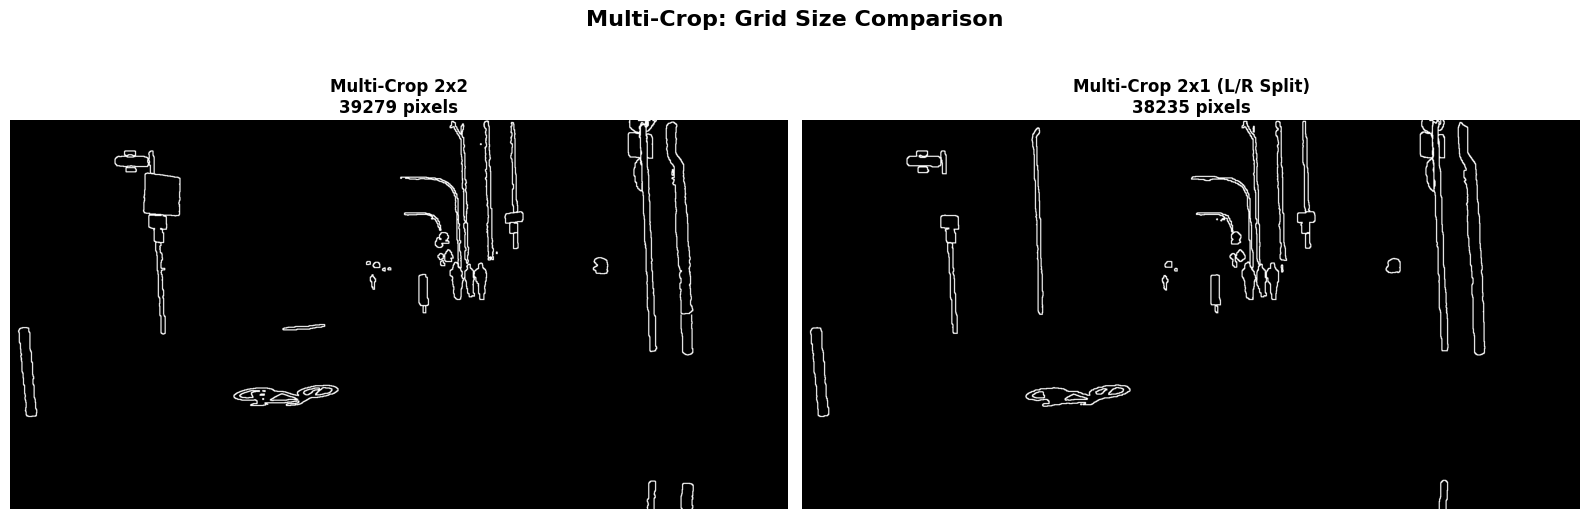

2x1 Grid captures 38,235 boundary pixels


In [13]:
# Optional: Try different parameters for multi-crop
print("\n" + "="*60)
print("Testing Multi-Crop with 2x1 Grid (Left/Right Split)")
print("="*60)

boundary_multi_crop_2x1 = strategy_multi_crop(
    image, model, processor, DEVICE,
    grid_size=(1, 2)  # 1 row, 2 columns = left/right split
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(boundary_multi_crop, cmap='gray')
axes[0].set_title(f"Multi-Crop 2x2\n{boundary_multi_crop.sum()} pixels", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(boundary_multi_crop_2x1, cmap='gray')
axes[1].set_title(f"Multi-Crop 2x1 (L/R Split)\n{boundary_multi_crop_2x1.sum()} pixels", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.suptitle("Multi-Crop: Grid Size Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"2x1 Grid captures {boundary_multi_crop_2x1.sum():,} boundary pixels")